In [1]:
ALGORITHM = 'Decision Tree'
ALGORITHM_DETAIL = 'random search'
DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

OVERRIDE_CV, OVERRIDE_N_ITER, OVERRIDE_JOBS = None, None, None

debug_mode = False
quick_mode = False

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

selected_model = DecisionTreeRegressor()

if quick_mode:
    OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10


In [3]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt


#confirm_colab = True
confirm_colab = False
IN_CLOUD = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB and not IN_CLOUD:
    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221107 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time, get_results, update_results

    set_csv_directory('final_split')
else:
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', 'zfunctions'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221109 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time, get_results, update_results


In [4]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [5]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [6]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../data/final/df_listings_v06.csv
(46871, 9)


In [7]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [8]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [9]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [10]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [11]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [12]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [13]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [14]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [15]:
starter_pipe = make_modelling_pipeline(selected_model, DATA_DETAIL)
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model', DecisionTreeRegressor())])

In [16]:
fitted_graph_model = starter_pipe[-1]
default_model_params = fitted_graph_model.get_params()
default_model_params

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [17]:
%timeit starter_pipe.fit(X_train, y_train)

347 ms ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
options_block = {
    'splitter': ['best', 'random'],
    'random_state': None,
    'min_weight_fraction_leaf': [0.0, 0.1, 0.25, 0.5],  #, 1, 5],
    'min_samples_split': [2, 4, 8, 50, 100, 200, 500],  # , .5, 1]
    'min_samples_leaf': [1, 0.25, 0.5, 1.5, 2, 4, 8, 50],
    'min_impurity_decrease': [0.0, 0.1, 0.25, 1, 5],
    'max_leaf_nodes': [None, 2, 5, 10, 50, 100, 200, 500],  # 1]
    'max_features': [None, 1.0, 'sqrt', 'log2', .5, .25, .1, 2],
    'max_depth': [None, 1, 2, 5, 10, 50],
    # 'criterion': ['gini','entropy','log_loss'], gini and entropy apply to classifier, not regressor
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],  #,'log_loss'],
    'ccp_alpha': [0.0, 0.05, 0.1, 0.25, 1, 5],  # Cost Complexity Pruning, ref 13.3.1

}

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

param_options, OVERRIDE_CV, OVERRIDE_N_ITER

({'model__splitter': ['best', 'random'],
  'model__random_state': [None],
  'model__min_weight_fraction_leaf': [0.0, 0.1, 0.25, 0.5],
  'model__min_samples_split': [2, 4, 8, 50, 100, 200, 500],
  'model__min_samples_leaf': [1, 0.25, 0.5, 1.5, 2, 4, 8, 50],
  'model__min_impurity_decrease': [0.0, 0.1, 0.25, 1, 5],
  'model__max_leaf_nodes': [None, 2, 5, 10, 50, 100, 200, 500],
  'model__max_features': [None, 1.0, 'sqrt', 'log2', 0.5, 0.25, 0.1, 2],
  'model__max_depth': [None, 1, 2, 5, 10, 50],
  'model__criterion': ['squared_error',
   'friedman_mse',
   'absolute_error',
   'poisson'],
  'model__ccp_alpha': [0.0, 0.05, 0.1, 0.25, 1, 5]},
 None,
 None)

In [19]:
gs = RandomizedSearchCV(starter_pipe, param_options, cv=cv, n_jobs=n_jobs,
                        verbose=verbose, scoring=CROSS_VALIDATION_SCORING, refit=refit,
                        return_train_score=True, n_iter=n_iter, error_score='raise'),

cross_validation_result, average_cross_validation_fit_time = fit_model_with_cross_validation(gs, X_train, y_train,
                                                                                             fits=cv * n_iter)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Total fit/CV time: 82 seconds   (1668003435.309599 ==> 1668003518.1778529)
0.28 seconds per fit


In [20]:
best_estimator_pipe = cross_validation_result.best_estimator_

average_time = get_best_estimator_average_time(best_estimator_pipe, X_train, y_train,
                                               debug=debug_mode or average_cross_validation_fit_time < 300)
print(average_time)

[0.05582261085510254, 0.05431985855102539, 0.05167531967163086, 0.05506324768066406, 0.051473140716552734]
0.053670835494995114


In [21]:
if debug_mode:
    cross_validation_result.cv_results_

In [22]:
cv_results_df = pd.DataFrame(cross_validation_result.cv_results_)
cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))
cv_results_df.sort_values('rank_test_score')[
    ['params2', 'rank_test_score', 'mean_train_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']]

,params2,rank_test_score,mean_train_score,mean_test_score,mean_fit_time,mean_score_time,params
82,random/None/0.0/2/4/0.1/50/None/None/poisson/0.05,1,0.494121,0.488521,0.039677,0.003303,"{'model__splitter': 'random', 'model__random_s..."
23,best/None/0.0/50/2/0.25/200/0.25/None/friedman...,2,0.517164,0.481029,0.047750,0.003098,"{'model__splitter': 'best', 'model__random_sta..."
56,best/None/0.0/2/4/0.25/500/0.5/5/poisson/5,3,0.423642,0.421310,0.082533,0.002753,"{'model__splitter': 'best', 'model__random_sta..."
48,best/None/0.0/500/8/5/500/0.1/50/squared_error/5,4,0.385888,0.363516,0.051947,0.004368,"{'model__splitter': 'best', 'model__random_sta..."
1,random/None/0.0/200/8/0.0/200/0.25/10/poisson/...,5,0.339038,0.332733,0.024523,0.003561,"{'model__splitter': 'random', 'model__random_s..."
...,...,...,...,...,...,...,...
21,random/None/0.5/4/50/1/500/0.1/None/poisson/5,78,0.000000,-0.000059,0.012163,0.002000,"{'model__splitter': 'random', 'model__random_s..."
20,random/None/0.5/4/0.5/5/200/1.0/1/friedman_mse...,78,0.000000,-0.000059,0.012861,0.001939,"{'model__splitter': 'random', 'model__random_s..."
27,random/None/0.5/2/2/1/50/log2/None/friedman_ms...,78,0.000000,-0.000059,0.016839,0.002573,"{'model__splitter': 'random', 'model__random_s..."
71,random/None/0.5/4/4/5/5/0.5/1/squared_error/0.1,78,0.000000,-0.000059,0.015313,0.002438,"{'model__splitter': 'random', 'model__random_s..."


In [23]:
def print_results(cross_validation_result):
    means = cross_validation_result.cv_results_['mean_test_score']
    stds = cross_validation_result.cv_results_['std_test_score']
    params = cross_validation_result.cv_results_['params']
    times = cross_validation_result.cv_results_['std_test_score']

    print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
    print()
    for mean, std, param, time in zip(means, stds, params, times):
        #param2 = "/".join(list(param.values()))
        param2 = "/".join(list([str(c) for c in param.values()]))
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')

if debug_mode:
    print_results(cross_validation_result)

In [24]:
print('Best Index: ', cross_validation_result.best_index_)
print('Best Score: ', cross_validation_result.best_score_)
print('Best Params: ', cross_validation_result.best_params_)

Best Index:  82
Best Score:  0.488521055632817
Best Params:  {'model__splitter': 'random', 'model__random_state': None, 'model__min_weight_fraction_leaf': 0.0, 'model__min_samples_split': 2, 'model__min_samples_leaf': 4, 'model__min_impurity_decrease': 0.1, 'model__max_leaf_nodes': 50, 'model__max_features': None, 'model__max_depth': None, 'model__criterion': 'poisson', 'model__ccp_alpha': 0.05}


In [25]:
y_pred = best_estimator_pipe.predict(X_test)

In [26]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Decision Tree----------
R square Accuracy 0.4828212907254342
Mean Absolute Error Accuracy 61115.94180438482
Mean Squared Error Accuracy 5842260482.550115
Root Mean Squared Error 76434.68115031366


In [27]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [28]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754.0,400000.0,419355.375940,19355.375940,4.838844,4.615507
119328242.0,369950.0,388042.093541,18092.093541,4.890416,4.662405
125716790.0,350000.0,431801.777743,81801.777743,23.371936,18.944289
122440040.0,549000.0,431801.777743,117198.222257,21.347581,27.141672
120508103.0,495000.0,465908.228795,29091.771205,5.877125,6.244099
...,...,...,...,...,...
68620869.0,475000.0,545674.485185,70674.485185,14.878839,12.951767
85735665.0,575000.0,545674.485185,29325.514815,5.100090,5.374177
125706338.0,400000.0,419355.375940,19355.375940,4.838844,4.615507


In [29]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType


In [30]:
score = best_estimator_pipe.score(X_test, y_test)
score

0.4828212907254342

In [31]:
r2_score(y_test, y_pred)

0.4828212907254342

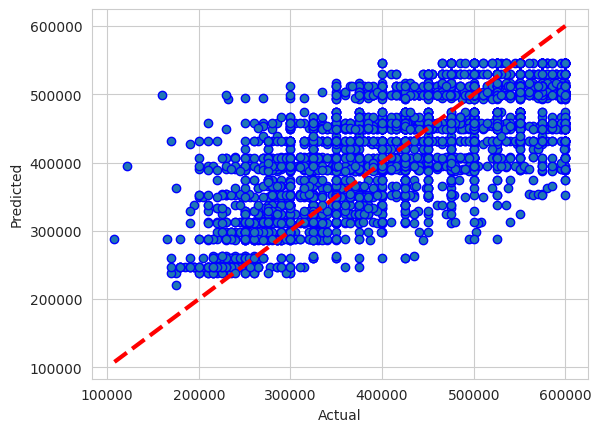

In [32]:
fig, ax = plt.subplots()
ax.scatter(y_test, best_estimator_pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [33]:
def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
    graph_model = model
    graph_model.set_params(**graph_params)
    graph_model.fit(X_train, y_train)
    y_pred_graph = model.predict(X_test)

    return model, y_pred_graph


best_model_count = 10 if not quick_mode else 2
best_model_count = 3 if not quick_mode else 1
best_models = {}
best_model_predictions = {}
best_model_scores = {}

for h in range(-1, best_model_count, 1):
    if h < 0:
        i = n_iter - 1
    elif h == 0:
        i = 0
    elif 10 * h > n_iter:
        continue
    else:
        i = 10 * h
    #print(h, i)

    graph_params_pipe = cv_results_df['params'][i]

    graph_params_pipe = cv_results_df.loc[cv_results_df['rank_test_score'] == 1, 'params'].values[0]

    graph_params = {}
    for key, value in graph_params_pipe.items():
        graph_params[key.replace('model__', '')] = value

    fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_params_pipe, X_train, y_train, X_test) # TODO RECHECK

    if h == -1:
        i = -1
    best_models[i] = fitted_graph_model
    best_model_predictions[i] = y_pred_graph
    best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

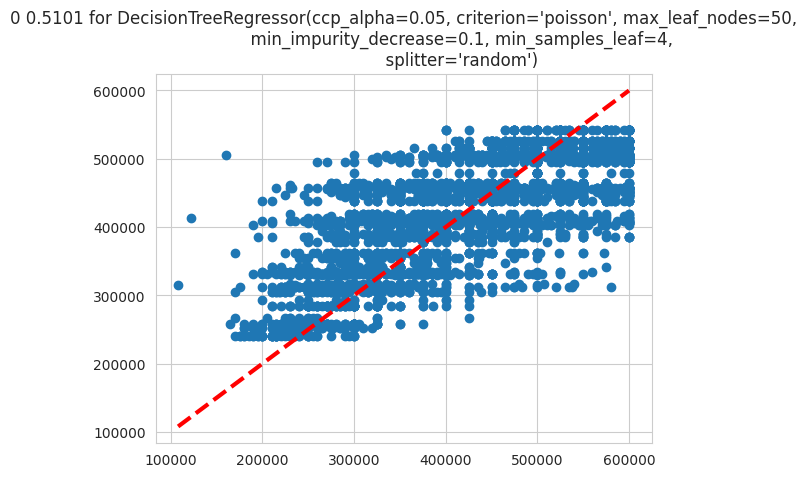

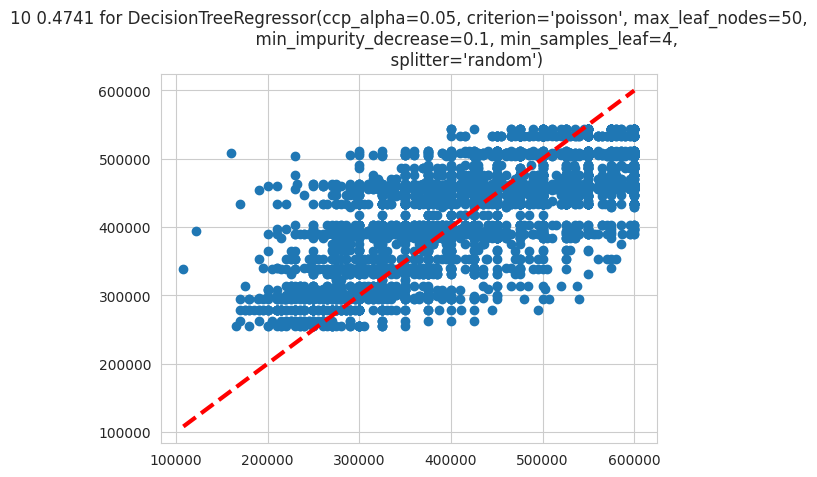

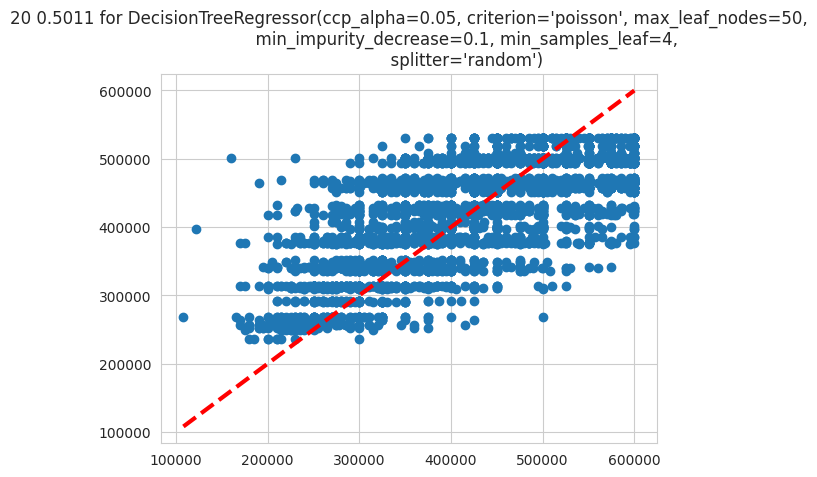

In [34]:
for i in best_model_scores.keys():
    if i >= 0:
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
        plt.scatter(y_test, best_model_predictions[i])
        plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
        plt.show()

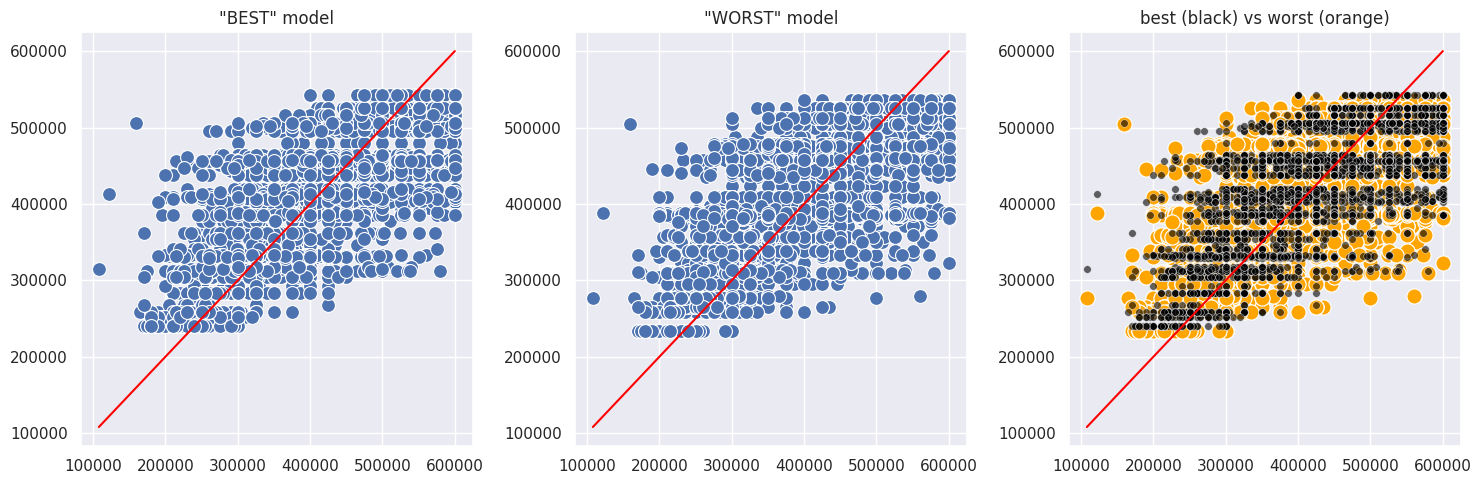

In [35]:
if True:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0], ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1], ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1], ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0], ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [36]:
results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    'params': cross_validation_result.best_params_
}

DD2 = "-" + "|".join(DATA_DETAIL) if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} - {ALGORITHM_DETAIL}{DD2} (v{VERSION})'.lower()

if not IN_COLAB:
    results_json = get_results()
    update_results(results_json, results, key)

print(key)
results

decision tree - random search (v06)


{'_score': 0.4828212907254342,
 'R square Accuracy': 0.4828212907254342,
 'Mean Absolute Error Accuracy': 61115.94180438482,
 'Mean Squared Error Accuracy': 5842260482.550115,
 'Root Mean Squared Error': 76434.68115031366,
 '_train time': 0.053670835494995114,
 'random_state': 101,
 'date': '2022-11-09 14:18:41.504802',
 'params': {'model__splitter': 'random',
  'model__random_state': None,
  'model__min_weight_fraction_leaf': 0.0,
  'model__min_samples_split': 2,
  'model__min_samples_leaf': 4,
  'model__min_impurity_decrease': 0.1,
  'model__max_leaf_nodes': 50,
  'model__max_features': None,
  'model__max_depth': None,
  'model__criterion': 'poisson',
  'model__ccp_alpha': 0.05},
 'first run': '2022-11-06 22:09:00.901821',
 'best params': 'MULTIPLE PARAM OPTIONS'}

In [37]:
with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
    pickle.dump(cross_validation_result.best_estimator_, f)

In [38]:
feature_importances = cross_validation_result.best_estimator_[-1].feature_importances_
#std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

indices = np.argsort(feature_importances)[::-1]

print('Feature Ranking:')

for f in range(X_train.shape[1]):
    print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]), df_features.columns[indices[f] + 1])


Feature Ranking:
1. features 9 (0.271141) tenure.tenureType_LEASEHOLD
2. features 0 (0.224694) bedrooms
3. features 6 (0.148444) longitude_deviation
4. features 5 (0.129925) latitude_deviation
5. features 4 (0.103211) location.longitude
6. features 1 (0.082692) bathrooms
7. features 10 (0.028049) tenure.tenureType_SHARE_OF_FREEHOLD
8. features 3 (0.008359) location.latitude
9. features 2 (0.003485) nearestStation
10. features 8 (0.000000) tenure.tenureType_FREEHOLD
11. features 7 (0.000000) tenure.tenureType_COMMONHOLD


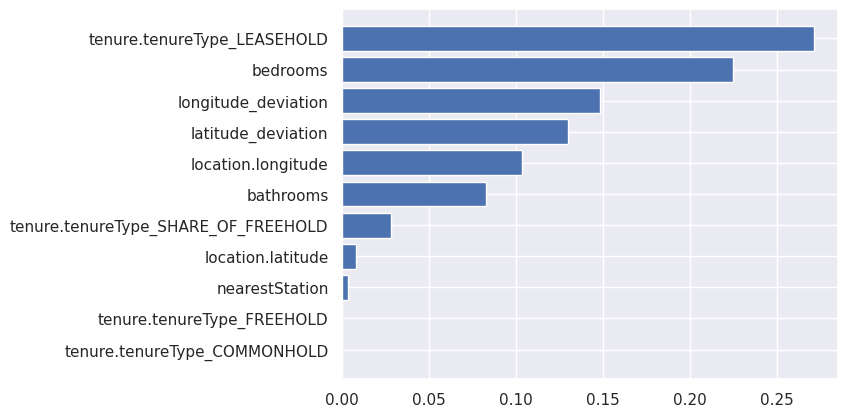

In [39]:
feature_importances = cross_validation_result.best_estimator_[-1].feature_importances_
indices = np.argsort(feature_importances)

fig, ax = plt.subplots()
ax.barh(range(len(feature_importances)), feature_importances[indices])
ax.set_yticks(range(len(feature_importances)))
_ = ax.set_yticklabels(df_features.columns[[c+1 for c in indices]])